In [ ]:
##!pip install --upgrade pip
##!pip install --upgrade setuptools
#!pip install --upgrade torch torchvision torchaudio
#!pip install --upgrade torchtext

In [1]:
import locale
def getpreferredencoding(do_setlocale = True):
    return "UTF-8"
locale.getpreferredencoding = getpreferredencoding

In [2]:
import nltk   
import spacy            
import re     
import string            
import numpy as np
import pandas as pd
import random
import collections
!pip install transformers
import matplotlib.pyplot as plt
from nltk.corpus import twitter_samples    # Corpus Twitter
from nltk.tokenize import word_tokenize 
import nltk
from nltk.stem import PorterStemmer
from nltk.tokenize import TweetTokenizer
nltk.download('punkt')
nltk.download('stopwords')
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import TensorDataset, DataLoader
import torch.nn as nn
import torch.optim as optim
import time
from sklearn.metrics import classification_report
from transformers import AutoTokenizer, AutoModel
from torch.utils.data import Dataset, TensorDataset, DataLoader, random_split, RandomSampler, SequentialSampler

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.1/7.1 MB 43.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.8/236.8 kB 30.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 93.8 MB/s eta 0:00:00


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Device: {device}')

Device: cuda


In [4]:
nltk.download('twitter_samples')

[nltk_data] Downloading package twitter_samples to /root/nltk_data...
[nltk_data]   Unzipping corpora/twitter_samples.zip.


True

In [5]:
pos_tweets = twitter_samples.strings('positive_tweets.json') #tweets positivos
neg_tweets = twitter_samples.strings('negative_tweets.json') #tweets negativos

print("Positive tweets: ", len(pos_tweets))
print("Negative tweets: ", len(neg_tweets))

Positive tweets:  5000
Negative tweets:  5000


In [6]:
def custom_tokenizer(nlp):
    special_cases = {":)": [{"ORTH": ":)"}], ":(": [{"ORTH": ":("}],":-(": [{"ORTH": ":-("}],}
    simple_url_re = re.compile(r'''^https?://''')
    suffixes = nlp.Defaults.suffixes + [r'''-+$''',]
    suffix_regex = spacy.util.compile_suffix_regex(suffixes)
    return spacy.tokenizer.Tokenizer(nlp.vocab, rules=special_cases, suffix_search=suffix_regex.search, url_match=simple_url_re.match)

nlp = spacy.load("en_core_web_sm")
nlp.tokenizer = custom_tokenizer(nlp)

In [7]:
def normalization(data, regularization="lemma", language='english'):
  stopwords = nltk.corpus.stopwords.words(language)
  ps = PorterStemmer()
  normalized_data = []
  
  for tweet in data:
    tweet = re.sub(r'^RT[\s]+', '', tweet) # identificar retweets
    tweet = re.sub(r'https?://[^\s\n\r]+', '', tweet) #eliminar links
    tweet = re.sub(r'#', '', tweet) #eliminar símbolo gato
    tweet = re.sub(r'@\w+', '', tweet) #eliminar palabras que inicias con @
    tweet = re.sub(r'\d+', '', tweet) #eliminar números
    tweet = re.sub(' +', ' ', tweet) #quitar espacios

    if regularization == "stem":
      tweetTokenizer = TweetTokenizer()
      words = tweetTokenizer.tokenize(tweet)
      tokens = [ps.stem(w) for w in words]
    if regularization == "lemma":
      doc = nlp(tweet)
      tokens = [token.lemma_ for token in doc]
    else:
      doc = nlp(tweet)
      tokens = [token.text for token in doc]
    
    normalized_tweets = [w.lower() for w in tokens if w.lower() not in stopwords and not w==' ' and w not in string.punctuation]
    normalized_data.append(normalized_tweets)
  return normalized_data

In [8]:
norm_pos = normalization(pos_tweets)
norm_neg = normalization(neg_tweets)

In [9]:
pos_tweets[0]

'#FollowFriday @France_Inte @PKuchly57 @Milipol_Paris for being top engaged members in my community this week :)'

In [10]:
norm_pos[0]

['followfriday', 'top', 'engage', 'member', 'community', 'week', ':)']

In [11]:
labels_pos = [1]*len(norm_pos) #etiqueta de sentimiento positivo es 1
labels_neg = [0]*len(norm_neg) #etiqueta de sentimiento negativo es 0
X = norm_pos + norm_neg
y = labels_pos + labels_neg
X_txt = pos_tweets + neg_tweets

In [12]:
SPLIT_TEST = 0.2
SUB_SPLIT_TEST = 0.98

In [13]:
X_train, X_test_eval, y_train, y_test_eval = train_test_split(X, y, test_size=SPLIT_TEST, random_state=42)
X_test, X_val, y_test, y_val = train_test_split(X_test_eval, y_test_eval, test_size=SUB_SPLIT_TEST, random_state=42)

In [14]:
_, X_txt_test_eval, _, y_txt_test_eval = train_test_split(X_txt, y, test_size=SPLIT_TEST, random_state=42)
X_txt_test, _, y_txt_test, _ = train_test_split(X_txt_test_eval, y_txt_test_eval, test_size=SUB_SPLIT_TEST, random_state=42)

In [15]:
print("Train set size: ", len(X_train))
print("Evaluation set size: ",len(X_val))
print("Test set size: ",len(X_test))

Train set size:  8000
Evaluation set size:  1960
Test set size:  40


In [16]:
BATCH_SIZE = 32
CORPUS = 'twitter-sentiment-analysis'
BERT_PATH = 'sentence-transformers/bert-base-nli-mean-tokens'

In [17]:
TOKENIZER = AutoTokenizer.from_pretrained(BERT_PATH, do_lower_case=True)

In [18]:
X_train[0]

[':(', 'matt']

In [19]:
MAX_LEN = max([len(words) for words in X_train + X_val + X_test])
MAX_LEN = MAX_LEN + 2 # CLS and SEP
MAX_LEN

54

In [20]:
def transformToListOfSents(list_of_list_of_words):
  return [' '.join(words) for words in list_of_list_of_words]

In [21]:
X_train_s = transformToListOfSents(X_train)
X_val_s = transformToListOfSents(X_val)
X_test_s = transformToListOfSents(X_test)

In [22]:
X_train_s[0]

':( matt'

In [23]:
def encode_sents(sents, max_len = MAX_LEN):
    input_ids_ = []
    attention_masks_ = []
    type_ids_ = []
    for i, sent in enumerate(sents):
        encoded_dict = TOKENIZER.encode_plus(
                            sent,                      # Sentence 1 to encode.
                            add_special_tokens = True,  # Add '[CLS]' and '[SEP]'
                            truncation = True,
                            max_length = max_len,       # Pad & truncate all sentences.
                            pad_to_max_length = True,
                            return_attention_mask = True,   # Construct attn. masks.
                            return_tensors = 'pt',     # Return pytorch tensors.
                      )
        
        # Add the encoded sentence to the list.    
        input_ids_.append(encoded_dict['input_ids'])
            
        # And its attention mask (simply differentiates padding from non-padding).
        attention_masks_.append(encoded_dict['attention_mask'])

        type_ids_.append(encoded_dict['token_type_ids'])
    return input_ids_, attention_masks_, type_ids_

In [24]:
def getEncodedTensors(sents,labels):
    input_ids, attention_masks, type_ids = encode_sents(sents)
    input_ids = torch.cat(input_ids, dim=0)
    attention_masks = torch.cat(attention_masks, dim=0)
    type_ids = torch.cat(type_ids, dim=0)
    labels = torch.tensor(labels)
    return input_ids, attention_masks, type_ids, labels

In [25]:
input_ids_train,attention_masks_train,type_ids_train,labels_train = getEncodedTensors(X_train_s, y_train)

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2364: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [26]:
input_ids_val, attention_masks_val, type_ids_val, labels_val = getEncodedTensors(X_val_s, y_val)

In [27]:
# Combine the training inputs into a TensorDataset.
train_dataset = TensorDataset(input_ids_train, attention_masks_train, type_ids_train, labels_train)
val_dataset = TensorDataset(input_ids_val, attention_masks_val, type_ids_val, labels_val)

In [28]:
# Create the DataLoaders for our training and test sets.
# We'll take training samples in random order. 
torch.manual_seed(42)
train_loader = DataLoader(
            train_dataset,  # The training samples.
            sampler = RandomSampler(train_dataset), # Select batches randomly
            batch_size = BATCH_SIZE # Trains with this batch size.
            #num_workers=2
        )
torch.manual_seed(42)
val_loader = DataLoader(
            val_dataset, # The validation samples.
            sampler = SequentialSampler(val_dataset), # Pull out batches sequentially.
            batch_size = BATCH_SIZE # Validate with this batch size.
            #num_workers=2
        )

In [29]:
train_tuple_list = [(y_train[i],x) for i, x in enumerate(X_train)]
val_tuple_list = [(y_val[i], x) for i, x in enumerate(X_val)]
test_tuple_list = [(y_test[i], x) for i, x in enumerate(X_test)]

In [30]:
print('Number of train batches: {}'.format(len(train_loader)))# número de batches
print('Number of validation batches: {}'.format(len(val_loader)))

Number of train batches: 250
Number of validation batches: 62


In [157]:
class BertBaseClassification(nn.Module):
  def __init__(self, num_classes = 1, attentions=True):
      super().__init__()
      self.bert = AutoModel.from_pretrained(BERT_PATH, output_attentions=attentions) #load the model
      # Return: 
      # last_hidden_state.shape -> [batch_size, num_tokens_in_sequence,hidden_size] (bert_base hidden_size = 768)
      # pooler_output.shape -> [batch_size, hidden_size] se utiliza una capa de pooling simple que aplica una transformación 
      # lineal seguida de una función de activación tangente hiperbólica (tanh) a la última representación oculta (last_hidden_state) del token [CLS].
      self.linear = nn.Linear(self.bert.config.hidden_size, 1)
      self.sigmoid = nn.Sigmoid()

  def forward(self, input_ids, type_ids, mask):
      bert_output =self.bert(input_ids=input_ids, token_type_ids = type_ids, attention_mask= mask)
      output = self.linear(bert_output.pooler_output)
      output = self.sigmoid(output)
      return output, bert_output

In [166]:
model = BertBaseClassification().to(device)

In [167]:
criterion = nn.BCELoss().to(device) #nn.BCELoss().to(device) # loss for binary classification 
LEARNING_RATE = 0.000008 #0.00001
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

In [168]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 109,483,009 trainable parameters


Entrenamiento

In [169]:
def accuracy(predictions, labels):
    rounded_preds = torch.round(predictions)
    correct = (rounded_preds == labels).sum().item()
    total = labels.size(0)
    return correct / total, rounded_preds

In [170]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [171]:
def train_loop(model,iterator,optimizer,criterion,device=device,clip = 1.0):
    #Training loop
    model.train()
    loss_sum = 0
    acc_sum = 0
    seed = 42
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    y_true = []
    y_pred = []

    for i, batch in enumerate(train_loader):
        
        b_input_ids = batch[0].to(device)
        b_attention_mask = batch[1].to(device)
        b_type_ids = batch[2].to(device)
        label = batch[3].to(device)

        optimizer.zero_grad()

        #Forward 
        outputs, _ = model(input_ids=b_input_ids, type_ids = b_type_ids, mask = b_attention_mask)
        outputs = outputs.squeeze(1)
        #Loss
        loss = criterion(outputs, label.float())
        #Backprop
        loss.backward()
        #prevent gradients from exploding
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        #Update params
        optimizer.step()

        #ACC
        #predicted_class = torch.argmax(outputs, axis=-1)
        #acc = torch.eq(predicted_class, label).float().mean()
        acc, predictions = accuracy(outputs, label)

        loss_sum += loss.item()
        acc_sum += acc

        y_true.extend(label.tolist())
        y_pred.extend(predictions.tolist())

    epoch_train_loss = loss_sum * BATCH_SIZE / len(iterator)
    epoch_train_acc = acc_sum * BATCH_SIZE / len(iterator)


    return epoch_train_loss, epoch_train_acc, y_true, y_pred


In [173]:
def evaluation_loop(model,iterator,criterion,device=device):
    #Evaluation loop
    seed = 42
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    y_true = []
    y_pred = []
    model.eval()
    with torch.no_grad():
        loss_sum = 0
        acc_sum = 0

        for i, batch in enumerate(val_loader):
            b_input_ids = batch[0].to(device)
            b_attention_mask = batch[1].to(device)
            b_type_ids = batch[2].to(device)
            label = batch[3].to(device)

            #Forward
            outputs, _ = model(input_ids=b_input_ids, type_ids = b_type_ids, mask = b_attention_mask)
            outputs = outputs.squeeze(1)
            #Loss
            loss = criterion(outputs, label.float())
            #ACC
            acc, predictions = accuracy(outputs, label)

            loss_sum += loss.item()
            acc_sum += acc

            y_true.extend(label.tolist())
            y_pred.extend(predictions.tolist())
        
        epoch_dev_loss = loss_sum * BATCH_SIZE / len(iterator)
        epoch_dev_acc = acc_sum * BATCH_SIZE / len(iterator)
    return epoch_dev_loss, epoch_dev_acc, y_true, y_pred

In [174]:
NUM_EPOCHS = 2
best_valid_loss = float('inf')
model_name = "bert-base-nli-sentiments"
target_names = ['Negative', 'Positive']
train_loss_values, val_loss_values = [], []

history = {"train": {"loss": [], "acc": []}, "test": {"loss": [], "acc": []}}

seed = 42
np.random.seed(seed)
random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

for epoch in range(NUM_EPOCHS):
    
    start_time = time.time()

    epoch_train_loss, epoch_train_acc, y_train_true, y_train_pred = train_loop(model,train_loader,optimizer,criterion,device)
    epoch_dev_loss, epoch_dev_acc, y_dev_true, y_dev_pred = evaluation_loop(model,val_loader,criterion,device)

    end_time = time.time()
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    train_loss_values.append(epoch_train_loss)
    val_loss_values.append(epoch_dev_loss)

    #nos quedamos con el modelo que tiene mejor pérdida de validación
    if epoch_dev_loss < best_valid_loss:
      best_valid_loss = epoch_dev_loss
      torch.save(model.state_dict(), model_name +'.pt')
    

    history["train"]["loss"].append(epoch_train_loss)
    history["train"]["acc"].append(epoch_train_acc)
    history["test"]["loss"].append(epoch_dev_loss)
    history["test"]["acc"].append(epoch_dev_acc)

    print('-' * 120)
    #print(f'Epoch: {epoch+1:03}/{NUM_EPOCHS} | Epoch Time: {epoch_mins}m {epoch_secs}s | Train loss: {epoch_train_loss:.4f} | Train acc: {epoch_train_acc:.4f} | Dev loss: {epoch_dev_loss:.4f} | Dev acc: {epoch_dev_acc:.4f}')
    print(f'Epoch: {epoch+1:03}/{NUM_EPOCHS} | Epoch Time: {epoch_mins}m {epoch_secs}s | Train loss: {epoch_train_loss:.4f} | Dev loss: {epoch_dev_loss:.4f}')
    print()
    print("Entrenamiento: ")
    print(classification_report(y_train_true, y_train_pred, target_names=target_names, digits=4))
    print()
    print("Validación: ")
    print(classification_report(y_dev_true, y_dev_pred, target_names=target_names, digits=4))

------------------------------------------------------------------------------------------------------------------------
Epoch: 001/2 | Epoch Time: 1m 20s | Train loss: 4.0747 | Dev loss: 0.5892

Entrenamiento: 
              precision    recall  f1-score   support

    Negative     0.9784    0.9701    0.9742      4012
    Positive     0.9702    0.9784    0.9743      3988

    accuracy                         0.9742      8000
   macro avg     0.9743    0.9743    0.9742      8000
weighted avg     0.9743    0.9742    0.9742      8000


Validación: 
              precision    recall  f1-score   support

    Negative     0.9990    0.9928    0.9959       972
    Positive     0.9930    0.9990    0.9960       988

    accuracy                         0.9959      1960
   macro avg     0.9960    0.9959    0.9959      1960
weighted avg     0.9959    0.9959    0.9959      1960

------------------------------------------------------------------------------------------------------------------------

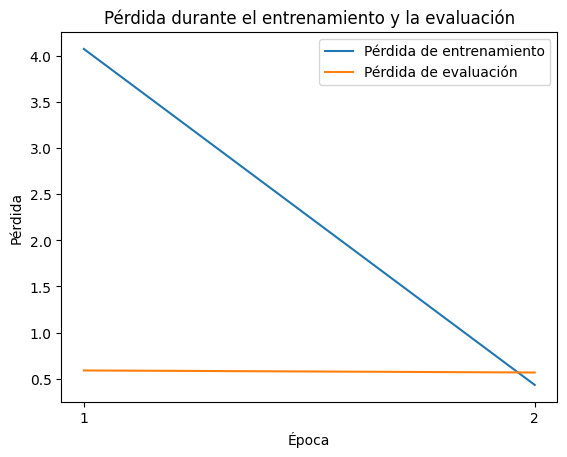

In [175]:
# Crear un objeto Figure y un objeto Axes.
fig, ax = plt.subplots()

# Desplazar los valores de iteración en el eje x y graficar las listas de pérdidas de entrenamiento y evaluación utilizando la función plot().
ax.plot([i+1 for i in range(len(train_loss_values))], train_loss_values, label='Pérdida de entrenamiento')
ax.plot([i+1 for i in range(len(val_loss_values))], val_loss_values, label='Pérdida de evaluación')

# Agregar etiquetas y títulos apropiados.
ax.set_xlabel('Época')
ax.set_ylabel('Pérdida')
ax.set_title('Pérdida durante el entrenamiento y la evaluación')

# Ajustar los ticks del eje x para que comience en la época 1.
ax.set_xticks([i+1 for i in range(len(train_loss_values))])

# Agregar una leyenda que explique qué línea corresponde a las pérdidas de entrenamiento y qué línea corresponde a las pérdidas de evaluación.
ax.legend()

# Mostrar la figura.
plt.show()

TEST

In [176]:
model.load_state_dict(torch.load(model_name+'.pt', map_location=torch.device(device)))

<All keys matched successfully>

In [177]:
def test_sentiment(num_example,model,device=device):
    print("Example: ", X_txt_test[num_example])
    tuple_sent = test_tuple_list[num_example]
    if tuple_sent[0] == 0:
      print("Target: Negative sentiment")
    else:
      print("Target: Positive sentiment")
    norm_txt = normalization([X_txt_test[num_example]])[0]
    print("Normalization: ", ' '.join(norm_txt))
    encoded = TOKENIZER.encode_plus(' '.join(norm_txt),add_special_tokens=True,truncation=True,max_length=MAX_LEN,
                                    return_attention_mask=True,return_tensors='pt')
    input = torch.cat([encoded['input_ids']], dim=0)
    att_masks = torch.cat([encoded['attention_mask']], dim=0)
    type_ids_ = torch.cat([encoded['token_type_ids']], dim=0)
    label = torch.tensor(y_txt_test[num_example])

    model.eval()
    with torch.no_grad():
      label = label.to(device)
      pred, bert_output = model(input_ids=input.to(device), type_ids = type_ids_.to(device), mask = att_masks.to(device))
      o = torch.round(pred.squeeze(1)).to(torch.int32)
    if o.item() == 0:
          print("Predicted: Negative sentiment")
    else:
          print("Predicted: Positive sentiment")

    return bert_output, input

In [178]:
#21, 33, 37, 39
NUM_EXAMPLE = 21
bert, input = test_sentiment(NUM_EXAMPLE,model)

Example:  @bae_ts WHATEVER STIL L YOUNG &gt;:-(
Target: Negative sentiment
Normalization:  whatever stil l young &gt :-(
Predicted: Negative sentiment


In [179]:
def trim_attention(att, input_ids):
    # Obtener la longitud de la secuencia de entrada sin el relleno
    input_len = np.count_nonzero(input_ids != 0)
    
    # Recortar la atención para eliminar el relleno
    att_trimmed = att[:input_len, :input_len]
    
    # Normalizar la atención para que las filas sumen 1
    att_trimmed = att_trimmed / att_trimmed.sum(axis=-1, keepdims=True)
    return att_trimmed, input_len

In [180]:
def view_attention(bert, input_ids, attention_layer):
    """
    Cuando se encuentra una palabra que no está en el vocabulario, el tokenizador de BERT la divide en 
    subpalabras más pequeñas y agrega el prefijo "#" a cada subpalabra para indicar que es parte de la
     misma palabra original. Por ejemplo, la palabra "running" podría ser dividida en "run" y "##ning".
    """
    # Obtener los pesos de atención (batch_size, num_heads, sequence_length, sequence_length)
    batch_idx = 0 #always 0 for test a sequence
    num_head =0
    fig, axs = plt.subplots(3, 4, figsize=(12, 9))
    for i, ax in enumerate(axs.flat):
      attention = bert.attentions[attention_layer][batch_idx][i].cpu().detach().numpy() 
      # Recortar la matriz de atención
      att_trimmed, sent_dim = trim_attention(attention, input_ids)
      sent = TOKENIZER.convert_ids_to_tokens(input_ids.squeeze().tolist())[:sent_dim]
      # Visualizar la matriz de atención recortada
      ax.matshow(att_trimmed, cmap='viridis')
      ax.set_title('Head ' + str(i+1))
      #axs[0].matshow(att_trimmed, cmap='hot')
      ax.set_xticks(np.arange(len(sent)), sent, rotation=90)
      ax.set_yticks(np.arange(len(sent)), sent)
      #plt.title('Atención del modelo BERT para dos oraciones')
    #print(sent)
    plt.tight_layout()
    plt.show()

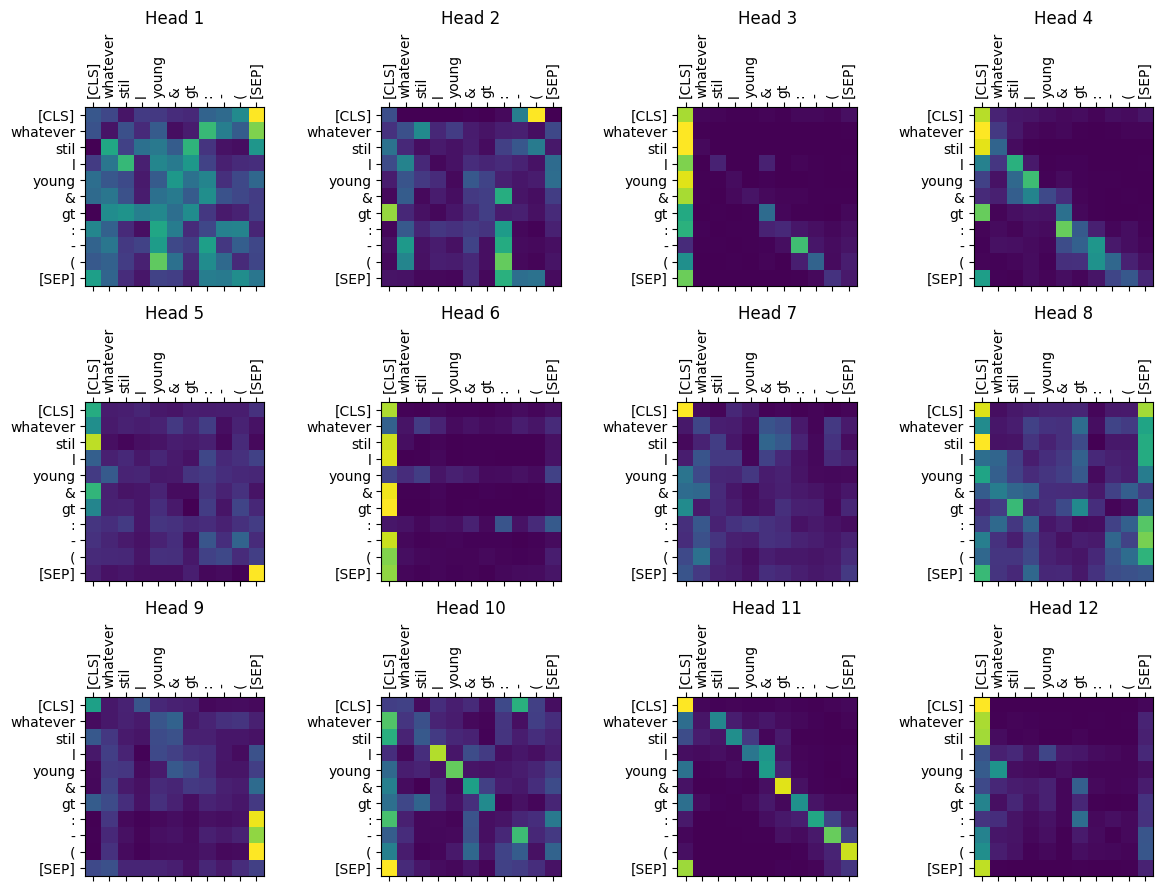

In [181]:
view_attention(bert, input, 0)